# What is a diagram?

[String diagrams](https://en.wikipedia.org/wiki/String_diagram), or **diagrams** in short, are a formal graphical language for representing the composition of **systems and processes**.
Formally, a diagram is an arrow in a [free monoidal category](https://en.wikipedia.org/wiki/Monoidal_category#Free_strict_monoidal_category).
This notebook spells out what this means in detail, and doing so it gives an overview of the architecture of DisCoPy.

## Systems and processes

### Categories

Let us start at the bottom of DisCoPy's architecture: the module [discopy.cat](../_api/discopy.cat.rst) which implements [free categories](https://en.wikipedia.org/wiki/Free_category).
First, a **category** $\mathbf{C}$ is a class of systems $\mathbf{C}_0$ and a class of processes $\mathbf{C}_1$, also called **objects** and **arrows** such that:

* each process $f : x \to y \in \mathbf{C}_1$ comes with input and output systems $\mathtt{dom}(f) = x \in \mathbf{C}_0$ and $\mathtt{cod}(f) = y \in \mathbf{C}_0$, also called the **domain** and **codomain**,
* each system $x \in \mathbf{C}_0$ comes with an **identity** process $1_x : x \to x$,
* processes are closed under **sequential composition**, i.e. there is a process $f g : x \to z$ for each composable pair $f : x \to y \in \mathbf{C}_1$ and $g : y \to z$,
* sequential composition is **associative**, i.e. $f (g h) = (f g) h$ whenever both sides are defined,
* identity processes are the **unit** of sequential composition, i.e. $1_x f = f = f 1_y$.

We call $\mathbf{C}(x, y) = \{ f \in \mathbf{C}_1 \ \vert \ \mathtt{dom}(f) = x, \ \mathtt{cod}(f) = y \}$ the **homset** from $x$ to $y$ in $\mathbf{C}$.

**Example:** We can define a category $\mathbf{Pyth}$ with Python types as objects and Python functions as arrows.
Since Python functions do not necessarily come with designated inputs and outputs, we need to add this information explicitly, this is what the module [discopy.python](../_api/discopy.python.rst) implements.

**Example:** Given a class $\mathbb{S}$ of numbers with addition and multiplication satisfying the axioms of a [rig](https://en.wikipedia.org/wiki/Rig_(mathematics)), we can define a category $\mathbf{Mat}_\mathbb{S}$ with natural numbers as objects, matrices with entries in $\mathbb{S}$ as arrows, i.e. $\mathbf{Mat}_\mathbb{S}(m, n) = \mathbb{S}^{m \times n}$.
Sequential composition is given by matrix multiplication with the identity matrix as unit.
This is implemented in [discopy.matrix](../_api/discopy.matrix.rst).

Now a **free category** $\mathbf{C}_G$ is one where the objects are nodes and the arrows are paths in a directed (multi) graph $G = (G_0, G_1, \mathtt{dom}, \mathtt{cod})$ which we call the **signature**.
The sequential composition is given by concatenation of paths with the empty path as unit.
The nodes $G_0$ are called generating objects, they are implemented by a class `Ob` with an attribute `name: str`.
The edges $G_1$ are called generating arrows or **boxes**, they are implemented by a class `Box` with an attribute `name: str` and two attributes `dom: Ob` and `cod: Ob`.

In [1]:
from discopy.cat import Ob, Box

x, y, z, w = [Ob(name) for name in "xyzw"]

f = Box('f', x, y)
g = Box('g', y, z)
h = Box('h', z, w)

Once we have defined objects and boxes, we can initialise an instance of the `Arrow` class by giving it a list of boxes `inside` and two objects `dom` and `cod`.
The `Arrow` class comes with a method `id` for the identity and `then` for sequential composition, shortened to `>>`.
In fact, we never need to initialise `Arrow` instances directly: we can construct every arrow in terms of identity and sequential composition.

In [2]:
from discopy.cat import Arrow

arrow = Arrow(inside=(f, g, h), dom=x, cod=w)

assert arrow == f >> g >> h == Arrow.id(x).then(f, g, h)

**Remark:** DisCoPy uses `tuple` rather than `list` so that the boxes in an arrow are immutable.

We can check that this satisfies the axioms of categories.
Indeed, the unit and associativity of sequential composition come for free from that of Python tuples.

In [3]:
assert f >> (g >> h) == (f >> g) >> h
assert Arrow.id(f.dom) >> f == f == f >> Arrow.id(f.cod)

Note that in order for this last equation to make sense, we need `Box` to be a subclass of `Arrow`. This leads to an interesting circularity: a box is an arrow with the list of just itself inside.

In [4]:
assert f.inside == (f, )

As a running example, let us define a signature with cooking ingredients as objects and cooking steps as boxes.
Then an arrow will be a recipe, i.e. a path in the graph of cooking.
Here is a simple example of cooking `Recipe` as a subclass of `Arrow`.

In [5]:
from __future__ import annotations
from discopy.cat import factory

class Ingredient(Ob):
    """ An ingredient is just an object. """

@factory
class Recipe(Arrow):
    """ A recipe is just an arrow. """
    inside: tuple[Step, ...]
    dom: Ingredient
    cod: Ingredient

class Step(Box, Recipe):
    """ A step is just a box in a recipe. """

**Remark:** In order for the identity and the composition of recipes to return a recipe rather than an arrow, we use the [factory](../_api/discopy.cat.factory.rst) decorator.

In [6]:
white = Ingredient('white')
foam = Ingredient('foam')
meringue = Ingredient('meringue')

whisk = Step('whisk', white, foam)
bake = Step('bake', foam, meringue)

recipe = whisk >> bake

assert isinstance(recipe, Recipe)

### Functors

Category theory can be thought of as the mathematics of mathematics.
We can make this meta mindset explicit if we define $\mathbf{Cat}$, the **category of categories**.
In order to avoid paradoxes, we say that the objects in $\mathbf{Cat}_0$ are all the *small* categories and $\mathbf{Cat}$ itself is *big* so that $\mathbf{Cat} \not\in \mathbf{Cat}_0$.

The arrows $\mathbf{Cat}_1$ between categories are called **functors**.
A functor $F : \mathbf{C} \to \mathbf{D}$ is a pair of maps $F_0 : \mathbf{C}_0 \to \mathbf{D}_0$ from objects to objects and $F_1 : \mathbf{C}_1 \to \mathbf{D}_1$ from arrows to arrows which respect the domain, codomain, identity and composition.

**Example:** There is a functor $F : \mathbf{Mat}_\mathbb{S} \to \mathbf{Pyth}$ which sends a natural number $n$ to the type of $n$-dimensional vectors with entries in $\mathbb{S}$ (assuming we can define this type in Python).
It sends a matrix $f : m \to n$ to the function which multiplies $m$-dimensional vectors by $f$ to get $n$-dimensional vectors.

**Example:** The functors from $\mathbf{Pyth}$ to itself can be thought of as data containers. For example, we can define a functor which sends every type `t` to `list[t]` and every function `f` to pointwise application `lambda xs: [f(x) for x in xs]`. Programming with functors is much more common in Haskell than in Python, see Milewski's [Programming Café](https://bartoszmilewski.com/2014/01/14/functors-are-containers/) for a wonderful introduction.

We're now ready to spell out what it means for $\mathbf{C}_G$ to be a free category.
Signatures and arrows between them (i.e. [graph homomorphisms](https://en.wikipedia.org/wiki/Graph_homomorphism)) form a category $\mathbf{Sig}$, which comes with a **forgetful functor** $\mathbf{Cat} \to \mathbf{Sig}$: it sends a category $\mathbf{D}$ to its underlying graph $U_\mathbf{D}$ by forgetting the composition and identity.
Going in the other direction, the **free functor** $\mathbf{Sig} \to \mathbf{Cat}$ sends a signature to its free category.
These two functors are related by an [adjunction](https://en.wikipedia.org/wiki/Adjoint_functors), i.e. a [natural isomorphism](https://en.wikipedia.org/wiki/Natural_transformation#natural_isomorphism):

$$\mathbf{Cat}(\mathbf{C}_G, \mathbf{D}) \simeq \mathbf{Sig}(G, U_\mathbf{D})$$

What this means in practice is that to define a functor $F : \mathbf{C}_G \to \mathbf{D}$ from a free category, it is equivalent to define a homomorphism of signatures $F : G \to U_\mathbf{D}$, i.e. an interpretation for each generating object and box.
This is implemented by the class `Functor`, which is initialised by a pair of maps `ob` from objects to objects and `ar` from boxes to arrows.
Functors also have an optional `cod: Category`, i.e. a pair of classes for objects and arrows, `Ob` and `Arrow` by default.
Note that the domain of a DisCoPy functor is implicit: it is the free category generated by the domain of its `ob` and `ar` maps.

**Example:** We can define a functor $F : \mathbf{C}_G \to \mathbf{C}_G$ which sends ingredients to their translation in French and cooking steps to more detailed recipes.

In [7]:
from discopy.cat import Category, Functor

Cooking = Category(Ingredient, Recipe)

blanc, mousse = Ingredient('blanc'), Ingredient('mousse')

saler = Step('saler', blanc, blanc)
battre = Step('battre', blanc, mousse)
cuire = Step('cuire', mousse, meringue)
refroidir = Step('refoidir', meringue, meringue)

recette = saler >> battre >> cuire >> refroidir

F = Functor(
    ob={white: blanc, foam: mousse, meringue: meringue},
    ar={whisk: saler >> battre, bake: cuire >> refroidir},
    dom=Cooking, cod=Cooking)

assert F(recipe) == recette

We can check that functors respect the structure of categories. 

In [8]:
assert F(recipe.dom) == F(recipe).dom
assert F(recipe.cod) == F(recipe).cod
assert F(Recipe.id(white)) == Recipe.id(F(white))
assert F(whisk >> bake) == F(whisk) >> F(bake)

**Example:** We can define a functor $F : \mathbf{C}_G \to \mathbf{Pyth}$ which sends cooking recipes to string-valued functions. In this case, it is easier to use functions rather than dictionaries for the `ob` and `ar` mappings.

In [9]:
from discopy import python

Pyth = Category(python.Ty, python.Function)

G = Functor(
    ob=lambda _: str,
    ar=lambda box: lambda x: box.name.removesuffix('e') + f'ed {x}',
    dom=Cooking, cod=Pyth)

assert G(recipe)("white") == "baked whisked white"

**Example:** We can define a functor $F : \mathbf{C}_G \to \mathbf{Cat}$ which sends ingredients to categories and cooking steps to functors.

In [10]:
Cat = Category(Category, Functor)

H = Functor(
    ob={white: Cooking, foam: Cooking, meringue: Pyth},
    ar={whisk: F, bake: G},
    dom=Cooking, cod=Cat)

assert H(whisk >> bake)(recipe)("white")\
    == (F >> G)(recipe)("white")

**Example:** Going from cooking and general abstract nonsense (the nickname of category theory) to quantum computing, we can define the simulation of quantum circuits as a functor $\mathtt{eval} : \mathbf{Circ} \to \mathbf{Mat}_\mathbb{C}$ where $\mathbf{Circ}$ is a free category with quantum gates as boxes.
This is a simplified version of the [discopy.quantum.circuit](../_api/discopy.quantum.circuit.rst) module.

In [11]:
from discopy.matrix import Matrix

Mat_C = Category(int, Matrix[complex])

qubit = Ob("qubit")

@factory
class Circuit(Arrow):
    """ A Circuit is an Arrow with an eval method. """
    def eval(self):
        F = Functor(
            ob={qubit: 2},
            ar=lambda box: box.array,
            cod=Mat_C)
        return F(self)

class Gate(Box, Circuit):
    """ A Gate is a Box with a name and an array. """
    def __init__(self, name, array, dom=qubit, cod=qubit):
        self.array = array
        Box.__init__(self, name, dom, cod)

We can use this simple simulator to check that the [Pauli gates](https://en.wikipedia.org/wiki/Quantum_logic_gate#Pauli_gates_(X,Y,Z)) are self-inverse.

In [12]:
Id = Circuit.id(qubit)
X = Gate('X', [0, 1, 1, 0])
Y = Gate('Y', [0, -1j, 1j, 0])
Z = Gate('Z', [1, 0, 0, -1])

assert (X >> X).eval() == (Y >> Y).eval() == (Z >> Z).eval()\
    == Id.eval() == Matrix[complex].id(2)

Let us summarise what we've discussed so far:

* A category is a collection of systems and processes with identity and sequential composition.
* The free category is generated by a graph where the edges are called `Box`, it has `Ob` as systems and `Arrow` as processes.
* A functor is a structure-preserving map between categories. A DisCoPy `Functor` goes from the free category to any codomain, it is uniquely defined by its image on `Ob` and `Box`.

The main idea behind DisCoPy is to use arrows in free categories as data structures for representing processes at a high-level of abstraction.
These arrows can be evaluated as concrete computation by applying functors.
We can also simplify them using rewriting algorithms to optimise our cooking recipe or quantum circuit before we evaluate it.

### Dagger, sums and bubbles

So far, the arrows we have defined have a rather limited expressivity: they can only represent sequential compositions of processes.
The `Arrow` class implements three additional methods to extend the kinds of processes we can represent: `dagger`, `sum` and `bubble`.

#### Dagger and slicing

First, the dagger allows to encode **time reversal** of processes. Formally, a dagger category is a category $\mathbf{C}$ equipped with an **identity-on-object contravariant involution** functor $(\dagger) : \mathbf{C} \to \mathbf{C}^{op}$.
For example, the category $\mathbf{Mat}_\mathbb{C}$ of complex matrices has a dagger given by the conjugate transpose.
Given a signature $G$, we can freely add a dagger to each box $G^\dagger = G \cup \{ f^\dagger : y \to x \ \vert \ f : x \to y \in G \}$ and this generates the free dagger category $\mathbf{C}_G^\dagger$.
This is implemented by an optional argument `Box.is_dagger: bool` and a method `Arrow.dagger`, shortened to the list-reversal operator `[::-1]`.

In [13]:
assert f[::-1].dom == f.cod
assert f[::-1].cod == f.dom
assert Arrow.id(x)[::-1] == Arrow.id(x)
assert (f >> g)[::-1] == g[::-1] >> f[::-1]

**Remark:** The list-reversal operator `[::-1]` is a special case of **slicing**, which is very useful when implementing rewriting algorithms.

In [14]:
assert (f >> g >> h)[:1] == f
assert (f >> g >> h)[1:] == g >> h
assert (f >> g >> h)[3:2:-1].inside\
    == (f >> g >> h).inside[3:2:-1]

#### Sums and zeros

In some categories, it makes sense to add two parallel arrows, i.e. with the same domain and codomain.
This addition operation is usually required to distribute over the sequential composition and to have a unit called zero.
These are called categories **enriched in monoids**, for example the category of matrices with element-wise addition.
In the free monoid-enriched category, arrows are formal sums of parallel arrows.
This is implemented by a class `Sum` with an attribute `terms: tuple[Arrow, ...]` and optional attributes `dom` and `cod`.

In [15]:
from discopy.cat import Sum

assert f + f + f == Sum(terms=(f, f, f))
assert Arrow.zero(x, y) == Sum((), dom=x, cod=y)

zero = Arrow.zero(x, y)
f_, g_ = Box('f_', x, y), Box('g_', y, z)

assert zero + f == f == f + zero
assert (f + f_) >> g == (f >> g) + (f_ >> g)
assert f >> (g + g_) == (f >> g) + (f >> g_)

#### Bubbles, gradients and cuts

Sometimes we want to implement a process-valued operator which cannot be expressed in terms of sequential composition.
For reasons that will become clear in the next section, we call such unary operators on homsets **bubbles**.
The free category with bubbles can be defined by induction over the level of nesting, i.e. an $(n + 1)$-nested bubble is a box which takes an arrow with $n$-nested bubbles as argument.
This is implemented by the class `Bubble`, a subclass of `Box` with an attribute `arg: Arrow` and optional arguments `dom` and `cod`.

Examples include the exponential of square matrices (used e.g. in the [Schrödinger equation](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation)) and the element-wise application of a non-linear operator (used e.g. as [activation function](https://en.wikipedia.org/wiki/Activation_function) in neural networks).
Another example is the gradient of a parameterised matrix, check out the [diagrammatic differentiation](../notebooks/diag-diff.ipynb) notebook!

Historically, bubbles first appeared in the [existential graphs](https://en.wikipedia.org/wiki/Existential_graph#Alpha) of C.S. Peirce, a diagrammatic axiomatisation of first-order logic where bubbles are called **cuts**, they allow to encode **negation**.
Formulae are evaluated by applying a functor into the category of finite sets and binary relations, which is equivalent to Boolean matrices.
For example, here is an implementation of **system alpha**, a notation for propositional logic where atoms are given by boxes $P : x \to x$ and conjunction is given by sequential composition.

In [16]:
from discopy.cat import Bubble

Mat_B = Category(int, Matrix[bool])

@factory
class Formula(Arrow):
    """ A Formula is an Arrow with methods
        for negation `~` and conjunction `&`. """
    def __invert__(self):
        return Cut(self)
    
    def __and__(self, other):
        return self >> other

class Atom(Box, Formula):
    """ An Atom is a Box in a Formula. """
    def __init__(self, name):
        Box.__init__(self, name, x, x)

class Cut(Bubble, Formula):
    """ A Cut is a Bubble in a Formula. """

class Valuation(Functor):
    """ A Valuation is a Functor into Boolean matrices
        which sends x to 1 and Cut to pointwise negation. """
    def __init__(self, ar: dict[Atom, bool]):
        super().__init__(ob={x: 1}, ar=ar, cod=Mat_B)

    def __call__(self, other):
        if isinstance(other, Cut):
            return self(other.arg).map(lambda x: not x)
        return super().__call__(other)

Disjunction is given for free by the sum of arrows.
Let's implement this with a subclass of `Sum` which we attach to `Formula` using the `sum_factory` attribute.
We can then check that this indeed satisfies [De Morgan's laws](https://en.wikipedia.org/wiki/De_Morgan%27s_laws).

In [17]:
class Disjunction(Sum, Formula):
    """ A Disjunction is a Sum in a Formula. """

Formula.sum_factory = Disjunction
Formula.__or__ = Formula.__add__

P, Q = Atom('P'), Atom('Q')

for p in [True, False]:
    for q in [True, False]:
        V = Valuation({P: p, Q: q})
        assert V(~(P | Q)) == V(~P & ~Q)
        assert V(~(P & Q)) == V(~P | ~Q)

## A data structure for diagrams

The main limitation of the [discopy.cat](../_api/discopy.cat.rst) module is that arrows can only have one input and one output.
With [discopy.monoidal](../_api/discopy.monoidal.rst), we can implement processes where domain and codomain are lists of systems, together with a method for **parallel composition**.

Formally, a (strict) **monoidal category** $\mathbf{C}$ comes equipped with a two-argument functor called **tensor** $\otimes : \mathbf{C} \times \mathbf{C} \to \mathbf{C}$ which is associative with unit $1 \in \mathbf{C}$.
A two-argument functor, also called a [bifunctor](https://en.wikipedia.org/wiki/Bifunctor), is simply a functor from a [product category](https://en.wikipedia.org/wiki/Product_category), i.e. where objects and arrows are pairs.
The monoidal product is a generalisation of the [tensor product](https://en.wikipedia.org/wiki/Tensor_product) of linear maps and of the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of matrices.
Without loss of generality, we may assume that the objects of $\mathbf{C}$ form a **free monoid** $\mathbf{C}_0^\star$, i.e. they are lists of elements from some set $\mathbf{C}_0$ of generating objects.
(If you want to be technical, this is called a [coloured PRO](https://ncatlab.org/nlab/show/PRO).)

### Types and signatures

What we call a **type** is such a list of generating objects, it is implemented by `Ty`, a subclass of `Ob` with an attribute `inside: tuple[Ob, ...]`.
The default value is the empty tuple, i.e. the unit of the monoid.
The method `tensor` returns the concatenation of two types, it is shortened to `@`.
We can check that this indeed satisfies the axioms of a monoid.

In [18]:
from discopy.monoidal import Ty

x, y, z = map(Ty, "xyz")

assert x @ y @ z == Ty('x', 'y', 'z')\
    == Ty(Ob('x'), Ob('y'), Ob('z'))

unit = Ty()

assert unit @ x == x == x @ unit
assert (x @ y) @ z == x @ (y @ z)

Types can be indexed and sliced like Python strings, i.e.

In [19]:
assert x[0] == x and 'x'[0] == 'x'

t = x @ y @ z

assert t[:1] == t[:-2] == x
assert t[1:] == t[-2:] == y @ z

assert t[1:0:-1].inside == t.inside[1:0:-1]

Now a **monoidal signature** is a graph $G = (G_0, G_1, \mathtt{dom}, \mathtt{cod})$ where the edges have lists of nodes as source and target, i.e. with $\mathtt{dom}, \mathtt{cod} : G_1 \to G_0^\star$.
Again, we call the nodes in $G_0$ objects and the edges in $G_1$ boxes, but now boxes have types (i.e. lists of objects) as domain and codomain.
This is implemented by the class `monoidal.Box`, which comes with a method `draw` which now justifies its name: a `Box` is drawn as a box with its domain and codomain as input and output wires.

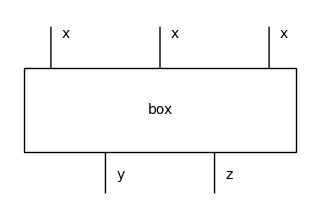

In [20]:
from discopy.monoidal import Box

box = Box('box', x @ x @ x, y @ z)

box.draw(figsize=(3, 2))

Boxes with the empty list as domain and codomain are called a **states** and **effects** respectively.
A **scalar** is both a state and an effect.

### Free monoidal categories

We can finally get to our definition of diagrams: they are **arrows in a free monoidal category**.
Let's spell this out.
We have a category $\mathbf{MonCat}$ with monoidal categories as objects and monoidal functors as arrows, i.e. functors which respect the tensor.
Similarly, $\mathbf{MonSig}$ is the category of monoidal signatures and homomorphisms between them.
And again, we have a forgetful functor $U : \mathbf{MonCat} \to \mathbf{MonSig}$.
(This is where we need to assume our monoidal categories are in fact coloured PROs).
We want to construct its left-adjoint, i.e. the functor $F : \mathbf{MonSig} \to \mathbf{MonCat}$ which sends a monoidal signature $G$ to the free monoidal category $\mathbf{C}_G$ with a natural isomorphism:

$$\mathbf{MonCat}(\mathbf{C}_G, \mathbf{D}) \simeq \mathbf{MonSig}(G, U_\mathbf{D})$$

If you know some abstract algebra, then you know the brute force way to implement such a beast.
First, we give a recursive definition of all the string diagrams:

* every box $f : x \to y \in G$ is also a diagram $f : x \to y \in \mathbf{C}_G$,
* for every type $x \in G_0^\star$, the **identity** $1_x : x \to x$ is a diagram drawn as a bunch of parallel wires,
* for every composable pair of diagrams $f : x \to y$ and $g : y \to z$, their **composition** $f g : x \to z$ is a diagram drawn as vertical concatenation,
* for every pair of diagrams $f : x \to y$ and $f' : x' \to y'$, their **tensor** $f \otimes f' : xx' \to yy'$ is diagram drawn as horizontal juxtaposition.

Next, we realise that some diagrams appear multiple times, e.g. $f (g h)$ and $(f g) h$, so that we need to take a **quotient**, i.e. putting two formulae in the same **equivalence class** if they represent the same diagram.
Again, this equivalence relation is defined recursively: if $f \sim f'$ and $g \sim g'$ then $(f g) \sim (f' g')$ and $(f \otimes g) \sim (f' \otimes g')$.
The base case is given by the axioms of monoidal categories, namely:

* **associativity**: $f (g h) \sim (f g) h$ and $f \otimes (f' \otimes f'') \sim (f \otimes f') \otimes f''$
* **unit**: $(1_x f) \sim f \sim (f 1_y)$ and $(1 \otimes f) \sim f \sim (f \otimes 1)$
* **interchange:** $(1_x \otimes 1_y) \sim 1_{xy}$ and $(f g) \otimes (f' g') \sim (f \otimes f') (g \otimes g')$

### Layers and whiskering

While the first two are straightforward, the third axiom corresponds to the tensor being a bifunctor: a) the tensor of identity is the identity of tensor and b) the tensor of a pair of compositions is the composition of a pair of tensors.
This second part is the most challenging to implement.
Indeed, remember how we got the associativity and unit of sequential composition to hold for free from that of Python tuples.
We could try to play the same trick for the associativity and unit of parallel composition, but the interchange axiom forces these two types of tuples to distribute over one another.
In fact, we can use interchange to write every diagram in **generic form**, i.e. as a composition of tensors.
Furthermore, we can always write it so that every tensor expression contains exactly one box, e.g.

$$f \otimes f' = (f 1_y) \otimes (1_{x'} f') = (f \otimes 1_{x'}) (1_y \otimes f')$$

Such a tensor expression is called a **layer**, it takes the form $1_a \otimes f \otimes 1_b$ for some box $f$ in the middle and a pair of (possibly empty) types $a$ and $b$ on the left and right.
This is implemented by `Layer`, a subclass of `cat.Box` with three attributes `left: Ty`, `box: monoidal.Box` and `right: Ty`.

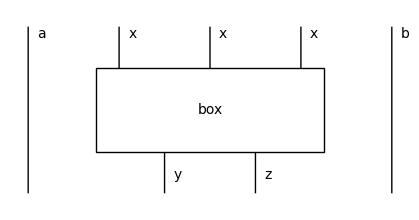

In [21]:
from discopy.monoidal import Layer

a, b, c = map(Ty, "abc")

layer = Layer(a, box, b)

(a @ box @ b).draw(figsize=(4, 2))

We can tensor a layer by a type on its left or right, this is called **whiskering**.

In [22]:
assert layer @ c == Layer(a, box, b @ c)
assert c @ layer == Layer(c @ a, box, b)

### Tensor and interchange

We can finally get to the core data structure of DisCoPy: a `Diagram` is an arrow with a list of layers `inside: tuple[Layer, ...]` and a method `tensor` for parallel composition, again shortened to `@`.
This is implemented in terms of whiskering using the previous formula:

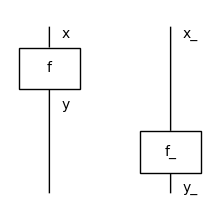

In [23]:
from discopy.monoidal import Diagram

x, y, x_, y_ = Ty('x'), Ty('y'), Ty('x_'), Ty('y_')

f, f_ = Box('f', x, y), Box('f_', x_, y_)

assert f @ f_ == f @ x_ >> y @ f_ == Diagram(
    inside=(
        Layer(Ty(), f, x_),
        Layer(y, f_, Ty())),
    dom=x @ x_,
    cod=y @ y_)

(f @ f_).draw(figsize=(2, 2))

In fact, the full list of layers is redundant.
In order to characterise a diagram uniquely, it is enough to give its domain, the list of its boxes and the **offset** for each box, i.e. the number of wires to its left.
The bijection between these two encodings is implemented by the methods `encode` and `decode`.

In [24]:
d = f @ f_

assert d.boxes == [box for _, box, _ in d.inside]
assert d.offsets == [len(left) for left, _, _ in d.inside]
assert d.encode() == (d.dom, list(zip(d.boxes, d.offsets)))\
                  == (x @ x_, [(f, 0), (f_, 1)])
assert Diagram.decode(x @ x_, [(f, 0), (f_, 1)]) == d

We can check that this satisfies all the axioms of monoidal categories for free...

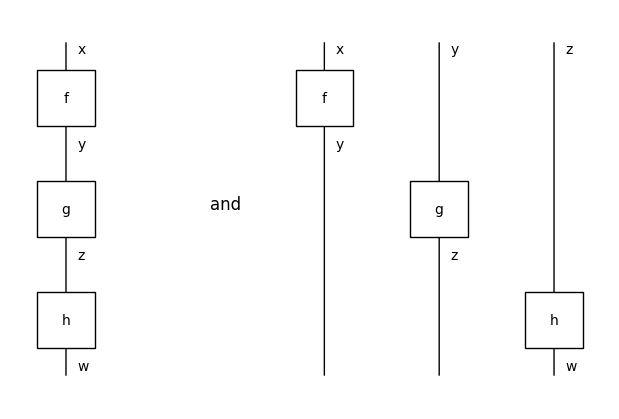

In [25]:
from discopy.drawing import Equation

g, h = Box('g', y, z), Box('h', z, w)

# Associativity
assert (f >> g) >> h == f >> (g >> h)
assert (f @  g) @  h == f @  (g @  h)

Equation((f >> g) >> h, (f @  g) @  h, symbol="and").draw(figsize=(6, 4))

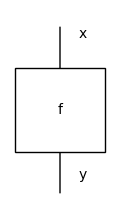

In [26]:
# Unit
assert Diagram.id(x) >> f == f == f >> Diagram.id(y)
assert Ty()          @  f == f == f @  Ty()

f.draw(figsize=(1, 2))

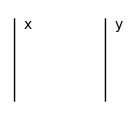

In [27]:
# Identity interchange
assert Diagram.id(x) @ Diagram.id(y) == Diagram.id(x @ y)

Diagram.id(x @ y).draw(figsize=(1, 1))

...except the interchange of `@` and `>>`!

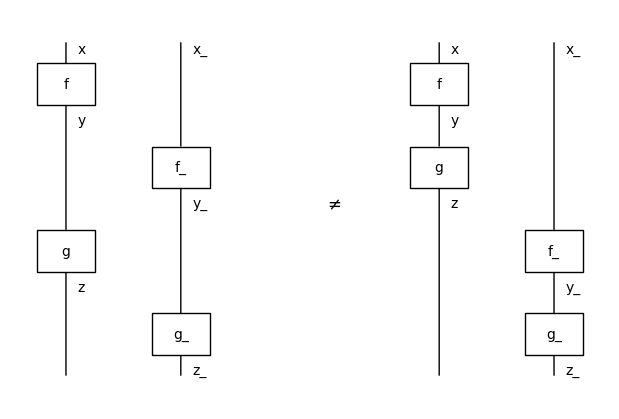

In [28]:
z_ = Ty('z_')
g_ = Box('g_', y_, z_)

assert (f @ f_) >> (g @ g_)\
    == (f @ x_) >> (y @ f_) >> (g @ y_) >> (z @ g_)\
    != (f @ x_) >> (g @ x_) >> (z @ f_) >> (z @ g_)\
    == (f >> g) @ (f_ >> g_)

Equation(
    (f @ f_) >> (g @ g_),
    (f >> g) @ (f_ >> g_),
    symbol="$\\neq$").draw(figsize=(6, 4))

If we assume that there are no side effects, then these two diagrams should represent the same process.
Indeed, the boxes `f_` and `g` are not connected so it should not matter which one we apply first: they happen in parallel.
If we interpret the connection of wires in terms of causality between processes, then the interchange axiom corresponds to the notion of [spacelike separation](https://en.wikipedia.org/wiki/Spacetime#Relativity_of_simultaneity) in relativity theory.

The equality of DisCoPy diagrams is implemented as the equality of Python tuples.
Thus two diagrams that have a different list of layers `inside` cannot be equal on the nose.
However, we can call the method `interchange` to rewrite between them.
It takes two indices `i` and `j` and returns the diagram with `self.boxes[i]` and `self.boxes[j]` interchanged, or raises `AxiomError` if they are connected.
This is what the general case looks like:

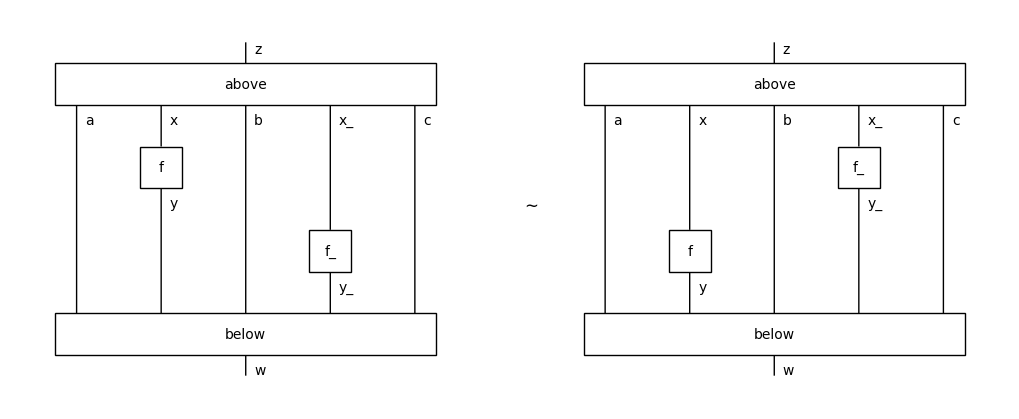

In [29]:
a, b, c = map(Ty, "abc")

above = Box('above', z, a @ x @ b @ x_ @ c)
below = Box('below',    a @ y @ b @ y_ @ c, w)

LHS = above >> a @ f @ b @ x_ @ c\
            >> a @ y @ b @ f_ @ c >> below

RHS = above >> a @ x @ b @ f_ @ c\
            >> a @ f @ b @ y_ @ c >> below

assert LHS.interchange(1, 2) == RHS
assert RHS.interchange(1, 2) == LHS

Equation(LHS, RHS, symbol="$\\sim$").draw(figsize=(10, 4))

One special case of interest is when we interchange an effect and a state with nothing between them, i.e. `y == b == x_ == Ty()`.
In this case there are two options which are controlled by an optional argument `left: bool`; the effect can end up on either side of the state, by default it goes to the right.

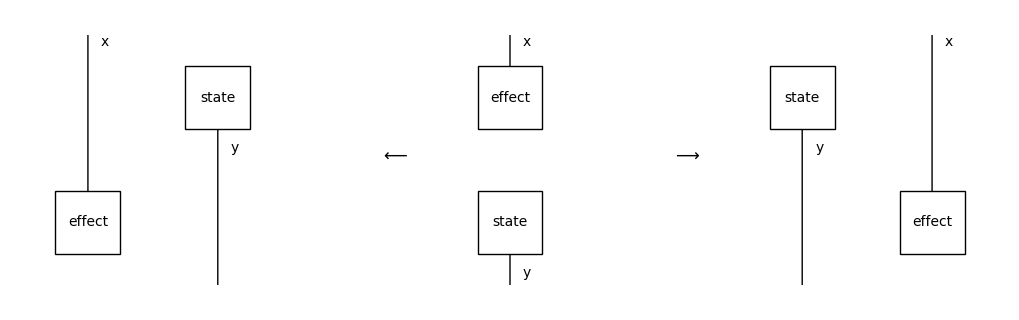

In [30]:
effect = Box('effect', x, Ty())
state = Box('state', Ty(), y)

right_interchange = (effect >> state).interchange(0, 1)
left_interchange = (effect >> state).interchange(0, 1, left=True)

Equation(left_interchange, Equation(effect >> state, right_interchange,
                  symbol='$\\longrightarrow$'), symbol='$\\longleftarrow$').draw(figsize=(10, 3))

### Normal form

We can also use the `normal_form` method which applies interchangers from the right to the left hand-side repeatedly, e.g.

In [31]:
assert ((f @ f_) >> (g @ g_)).normal_form()\
    == ((f >> g) @ (f_ >> g_)).normal_form() == (f >> g) @ (f_ >> g_)

This is guaranteed to terminate whenever the diagram is **boundary connected**, i.e. there is at most one connected component that is not connected to either the domain or the codomain.
In the opposite case, the following [Eckmann-Hilton argument](https://en.wikipedia.org/wiki/Eckmann%E2%80%93Hilton_argument) creates cycles of interchanges between diagrams with two scalars.

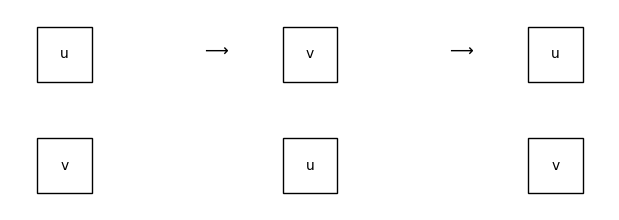

In [32]:
u, v = Box('u', Ty(), Ty()), Box('v', Ty(), Ty())

assert u @ v == u >> v
assert (u >> v).interchange(0, 1) == v >> u == v @ u
assert (u >> v).interchange(0, 1).interchange(0, 1) == u >> v

Equation(u @ v, v @ u, u @ v, symbol="$\\longrightarrow$").draw(figsize=(6, 2))

In the worst-case, a boundary-connected diagram with $n$ boxes will take $O(n^3)$ interchanges to reach a normal form.
For a proof of this theorem as well as the preceding one, we refer the reader to [Delpeuch and Vicary, LMCS 2022](https://lmcs.episciences.org/8960).
An example of this worst-case is given by the following family of spiral-shaped diagrams:

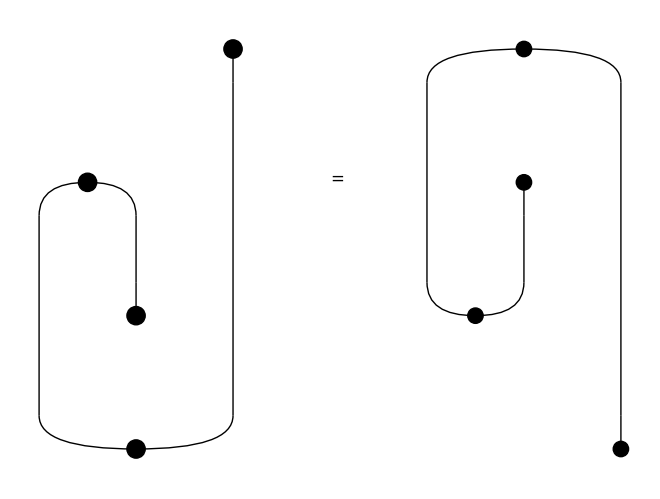

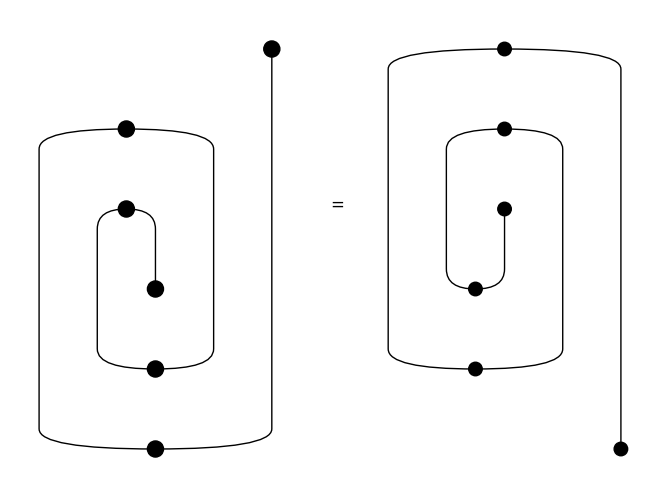

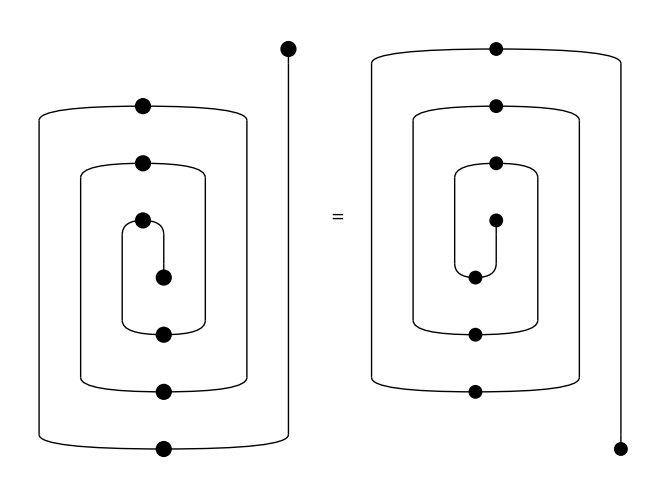

In [33]:
from discopy.drawing import spiral

for i in range(1, 4):
    Equation(spiral(i), spiral(i).normal_form()).draw(draw_type_labels=False)

We can iterate through the normalisation steps using the method `normalize` and visualise them as an animated picture using the method `to_gif`, e.g.

In [34]:
rewrite_steps = spiral(4).normalize()
Diagram.to_gif(*rewrite_steps, path="../_static/spiral.gif",
               draw_type_labels=False, figsize=(4, 6), loop=True)

This tutorial is still work-in-progress, stay tuned for the second half!

## Computing with functors

## Snakes, braids and spiders